# Exemplo de Image Matching usando LoFTR

Primeiro, vamos instalar tudo que precisamos:



*  Versão atualizada do [kornia](https://github.com/kornia/kornia) for [LoFTR](https://zju3dv.github.io/loftr/)
*  Versão atualizada do openCV para usar o MAGSAC++ na estimação geométrica
*  [kornia_moons](https://ducha-aiki.github.io/kornia_moons) para conversão e visualização


In [ ]:
%%capture
!pip install git+https://github.com/kornia/kornia
!pip install kornia_moons
!pip install opencv-python --upgrade

Baixamos o par de imagens que serão usados

In [ ]:
%%capture
!wget https://github.com/kornia/data/raw/main/matching/kn_church-2.jpg
!wget https://github.com/kornia/data/raw/main/matching/kn_church-8.jpg

Vamos definir os procedimentos de correspondência de imagens usando o algoritmo de identificação SIFT(Scale Invariant Feature Transform) do OpenCV. Usaremos o Kornia para fazer o match filtering. 

In [ ]:
import matplotlib.pyplot as plt
import cv2
import kornia as K
import kornia.feature as KF
import numpy as np
import torch
from kornia_moons.feature import *

def load_torch_image(fname):
    img = K.image_to_tensor(cv2.imread(fname), False).float() /255.
    img = K.color.bgr_to_rgb(img)
    return img

In [ ]:
%%capture

fname1 = 'kn_church-2.jpg'
fname2 = 'kn_church-8.jpg'

img1 = load_torch_image(fname1)
img2 = load_torch_image(fname2)


matcher = KF.LoFTR(pretrained='outdoor')

# O LoFTR funciona excusivamente na escala preto/branco
input_dict = {"image0": K.color.rgb_to_grayscale(img1), 
              "image1": K.color.rgb_to_grayscale(img2)}

with torch.no_grad():
    correspondences = matcher(input_dict)

Downloading: "http://cmp.felk.cvut.cz/~mishkdmy/models/loftr_outdoor.ckpt" to /root/.cache/torch/hub/checkpoints/loftr_outdoor.ckpt


  0%|          | 0.00/44.2M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/kornia/feature/loftr/utils/coarse_matching.py:255: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [i_ids % data['hw0_c'][1], i_ids // data['hw0_c'][1]],
/usr/local/lib/python3.7/dist-packages/kornia/feature/loftr/utils/coarse_matching.py:258: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [j_ids % 

In [ ]:
for k,v in correspondences.items():
    print (k)

keypoints0
keypoints1
confidence
batch_indexes


Refinamento das correspôndencias com o RANSAC(Random Sample Consensus) para estimar os parâmtros da matriz fundametal entre as imagens

In [ ]:
mkpts0 = correspondences['keypoints0'].cpu().numpy()
mkpts1 = correspondences['keypoints1'].cpu().numpy()
H, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.5, 0.999, 100000)
inliers = inliers > 0

Por último, plotar as correspondências com uma função do [kornia_moons](https://ducha-aiki.github.io/kornia_moons/feature.html#draw_LAF_matches). Boas correspondências vão para o espectro verde e más correspondências para o azul.


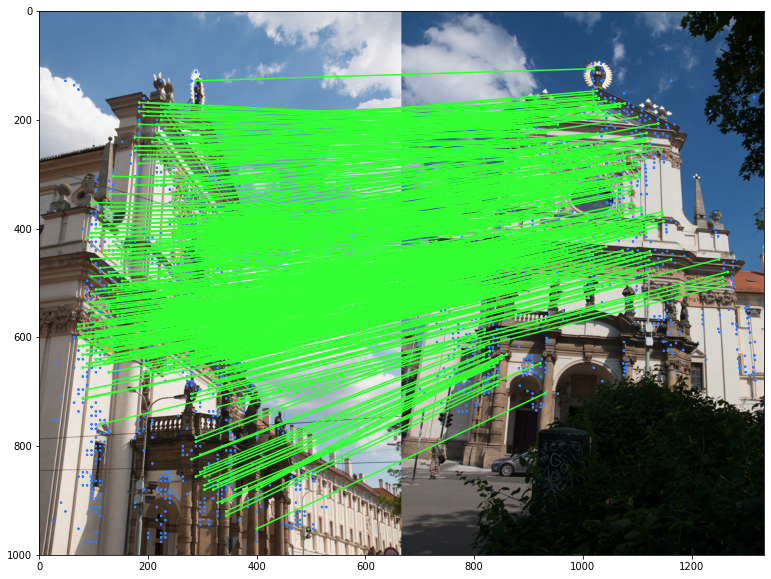

In [ ]:
draw_LAF_matches(
    KF.laf_from_center_scale_ori(torch.from_numpy(mkpts0).view(1,-1, 2),
                                torch.ones(mkpts0.shape[0]).view(1,-1, 1, 1),
                                torch.ones(mkpts0.shape[0]).view(1,-1, 1)),

    KF.laf_from_center_scale_ori(torch.from_numpy(mkpts1).view(1,-1, 2),
                                torch.ones(mkpts1.shape[0]).view(1,-1, 1, 1),
                                torch.ones(mkpts1.shape[0]).view(1,-1, 1)),
    torch.arange(mkpts0.shape[0]).view(-1,1).repeat(1,2),
    K.tensor_to_image(img1),
    K.tensor_to_image(img2),
    inliers,
    draw_dict={'inlier_color': (0.2, 1, 0.2),
               'tentative_color': None, 
               'feature_color': (0.2, 0.5, 1), 'vertical': False})